## Checking synchrotron kernel on power law electron spectrum

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from Radiation_simps import Radiation, plotEvolutionFromFile, Ne_fromFile, \
    Ny_fromFile, fitPowerLaw

import setFigureConfig as sfc
import coloring as cl



In [4]:
# properties of system
L_system = 5*10**16  # cm
B = 1  # G
# power law injection for source term
inj_N0 = 1e3  # norm
inj_si = -2  # spectral index
inj_min = 1e1
inj_max = 1e4
# Black Body
l_BB = 1  # norm
Theta_BB = 1e-5  # temperature (kT/mc^2)

In [5]:
r = Radiation(
    L=L_system, B=B, UinjUB=1,
    inj_N0=inj_N0, inj_min=inj_min, inj_max=inj_max, inj_si=inj_si,
    Theta_BB=Theta_BB, L_BLR=1, R_BLR=1, z_diss=2,
    yEscFactor=1
)

# set grid
r.setLinTime(dt=1e-3, saveEvery=1)
r.setLogElectronEnergy(eexpmin=0, eexpmax=6, NeE=200)
r.setLogPhotonEnergy(yexpmin=-13, yexpmax=-5, NyE=400)

# set initial definitions
# initial electron term
pivot = 1
qe = inj_N0 * (r.eE/pivot)**inj_si
eInitial = qe * ((r.eE > inj_min) & (r.eE < inj_max))
r.setInitalElectronDistribution(Ninitial=eInitial)
# initial photon term
yInitial = 0 * r.yE
r.setInitalPhotonDistribution(Ninitial=yInitial)

'''
commented = turned on
uncommented = turned off
'''
# escaqpe term has to be set to 1/s not 2/s
r.turnOff(
    [
        "Qe_injection",
        "Qe_yy",
        "Le_sync",
        "Le_icT",
        "Le_icKN",
        # "Ly_esc",
        "Ly_yy",
        # "Ly_ssa",
        # "Qy_sync",
        "Qy_icT",
        "Qy_icKN",
        "BB",
        "SSC"
    ]
)

l_B  = 0.0016165231439318074
l_BB = 1.0784281597449708e-13


In [8]:
# Size of the system: for all times L_system
T = 5
one = np.ones(int(T / r.dt) * 2)
zero = np.zeros(int(T / r.dt) * 2)
r.solveUntil(T=T, sArray=one, betaArray=zero, dopplerBBArray=one,
             printEvery=1000)

r.saveToh5("SynchrotronOnPowerLaw.h5")


start calculating..
 2020-01-26 14:07:29.991448
{'Qe_injection': 0, 'Qe_powerlaw': 0, 'Qe_yy': 0, 'Le_sync': 0, 'Le_icT': 0, 'Le_icKN': 0, 'Ly_esc': 1, 'Ly_yy': 0, 'Ly_ssa': 1, 'Qy_sync': 1, 'Qy_icT': 0, 'Qy_icKN': 0, 'BB': 0, 'SSC': 0}
finished calculating!
 2020-01-26 14:07:29.991912


/mnt/u/BlazarVariability/Lib/Radiation_simps.py:792: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axg.plot(self.yE, self.yE**ySlope * Ny, drawstyle="steps-mid")


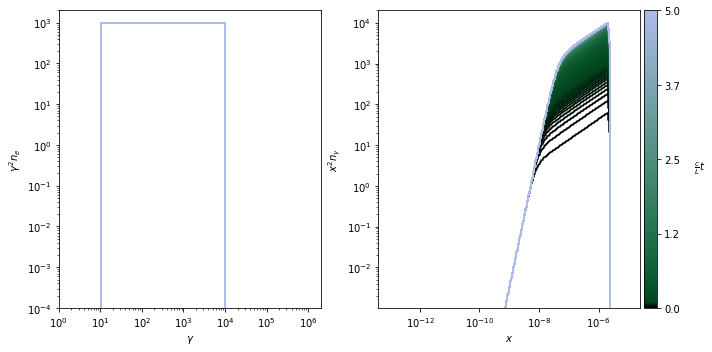

In [10]:
plt.show(r.plotEvolution(BB=False))

### Create plot for thesis

Fit e
norm:  999.9999999999998
si  :  -2.0
uncertainty: [[ 3.39883194e-28 -5.27331465e-32]
 [-5.27331465e-32  9.15148799e-36]]

Fit y 1
norm:  96855772033143.94
si  :  1.4972839698045506
uncertainty: [[ 1.37813877e+22 -2.05688818e+07]
 [-2.05688818e+07  2.05584009e-07]]

Fit y 2
norm:  2.1544007405968182e+17
si  :  -1.4757066517281034
uncertainty: [[ 8.62752982e+29 -2.21780901e+12]
 [-2.21780901e+12  8.33568095e-06]]


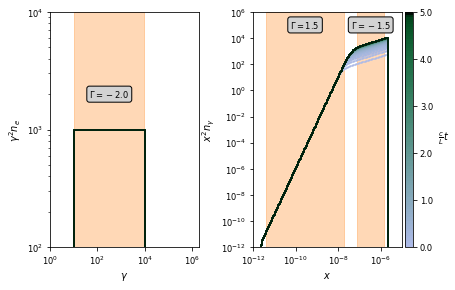

In [17]:
sfc.fullWidth(alpha=0.7)

filename_only = "SynchrotronOnPowerLaw.h5"

fig = plotEvolutionFromFile(
    "SynchrotronOnPowerLaw.h5", BB=False, cmap=cl.c_time(reverse=True), maxLines=100,
    nTicks=6
)

# electron fit
axe = fig.get_axes()[0]

eE, Ne = Ne_fromFile(filename_only)
fitRange = (eE > 1e1) & (eE < 1e4)
print("Fit e")
axe, popt, pcov = fitPowerLaw(
    eE[fitRange], Ne.iloc[-1].values[fitRange], guess=[1e3, -3],
    ax=axe, slope=2, height=2000, textpos="logCenter"
)

axe.set_ylim(1e2, 1e4)

# photon fit
axy = fig.get_axes()[1]

yE, Ny = Ny_fromFile(filename_only)

# fit 1
fitRange1 = (yE > 4e-12) & (yE < 2e-8)
print("\nFit y 1")
axy, popt, pcov = fitPowerLaw(
    yE[fitRange1], Ny.iloc[-1].values[fitRange1],
    pivot=1e-10, guess=[1e-6, 1.517],
    ax=axy, slope=2, height=1e5, textpos="logCenter"
)

# fit 2
fitRange2 = (yE > 8e-8) & (yE < 1.5*10**-6)
print("\nFit y 2")
axy, popt, pcov = fitPowerLaw(
    yE[fitRange2], Ny.iloc[-1].values[fitRange2],
    pivot=1e-7, guess=[1e3, -1.57],
    ax=axy, slope=2, height=1e5, textpos="logCenter"
)

# set limits
axy.set_ylim(1e-12, 1e6)
axy.set_xlim(1e-12, 1e-5)

fig.savefig("1_SynchrotronOnPowerLaw.pdf")